In [1]:
import os
import time as timer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import open3d as o3d
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from load_3d_data import load_data
from visualization_utils import visualize
import train_facetalk_utils as tu
import vae

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Define Constants

In [2]:
DATA_DIR = './data'
MODEL_DIR = './models'

EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
dh = 5000
dz = 500
beta = 0.75

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Helper Functions

In [3]:
"""
Utility functions
"""
def reshape_vertices(inversed):
    """
    Function to reshape the inversed principal components
    to vertices
    """
    vertices = []
    for i in range(len(inversed)):
        vert = np.reshape(inversed[i], (-1, 3))
        vertices.append(vert)
    
    return vertices

def vertices_to_meshes(vertices, ori_meshes):
    """
    Function to convert vertices to meshes
    using triangles from original meshes
    """
    meshes = []
    for i in range(len(vertices)):
        triangles = np.asarray(ori_meshes[i].triangles)
        mesh = o3d.geometry.TriangleMesh(
            o3d.utility.Vector3dVector(vertices[i]), 
            o3d.utility.Vector3iVector(triangles))
        mesh.compute_vertex_normals()
        mesh.compute_triangle_normals()
        mesh.paint_uniform_color([0.5, 0.5, 0.5])
        mesh.normalize_normals()
        meshes.append(mesh)
    return meshes

## Data Preparation

In [4]:
dirname = './data/FaceTalk'
files, expressions = load_data(dirname)
len(files)

1183

In [5]:
"""
Split to train and test set (90:10)
"""
X_train, X_test = train_test_split(files, test_size=.1, random_state=42)
len(X_train), len(X_test)

(1064, 119)

### Get Vertices from 3D Mesh

In [6]:
def get_vertices(files):
    """
    Function to get each 3d mesh file's vertices
    """
    vertices = []
    for file in files:
        vert = np.asarray(file.vertices)
        vert_reshaped = vert.reshape([1, -1])[0]
        vertices.append(vert_reshaped)
    return np.asarray(vertices)

In [7]:
X_train_v = get_vertices(X_train).reshape(-1, 5023, 3)
X_test_v = get_vertices(X_test).reshape(-1, 5023, 3)
X_train_v.shape, X_test_v.shape

((1064, 5023, 3), (119, 5023, 3))

In [8]:
train_dl = DataLoader(X_train_v, batch_size=BATCH_SIZE)
test_dl = DataLoader(X_test_v, batch_size=BATCH_SIZE)

In [9]:
[n, dx1, dx2] = X_train_v.shape

In [10]:
X_train_v = torch.Tensor(X_train_v)
X_test_v = torch.Tensor(X_test_v)

### Reshape Train and Test Data

In [11]:
X_train_reshaped = torch.reshape(X_train_v, (-1, dx1*dx2)).float()
X_test_reshaped = torch.reshape(X_test_v, (-1, dx1*dx2)).float()

X_train_reshaped.shape, X_test_reshaped.shape

(torch.Size([1064, 15069]), torch.Size([119, 15069]))

## Reconstruct Decoded

In [12]:
"""Load trained autoencoder"""
print(f"Using {DEVICE} device")

# Define model
model = vae.VAE_FT(d_in=dx1*dx2, d_z=dz, d_h=dh).to(DEVICE)

model_path = os.path.join(MODEL_DIR, "vae_ep100_facetalk.pth")
model.load_state_dict(torch.load(model_path))
model.eval()

print(model)

Using cuda device
VAE_FT(
  (encoder): Sequential(
    (0): Linear(in_features=15069, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=1000, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=5000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5000, out_features=15069, bias=True)
  )
)


In [13]:
X_train_reshaped = X_train_reshaped.to(DEVICE)
X_test_reshaped = X_test_reshaped.to(DEVICE)

In [15]:
X_train_recons, _, _ = model(X_train_reshaped)
X_test_recons, _, _ = model(X_test_reshaped)
X_train_recons.shape, X_test_recons.shape

(torch.Size([1064, 15069]), torch.Size([119, 15069]))

## Visualize Reconstructed Data

In [16]:
train_recons_vertices = np.asarray(reshape_vertices(X_train_recons.to('cpu').detach().numpy()))
test_recons_vertices = np.asarray(reshape_vertices(X_test_recons.to('cpu').detach().numpy()))

train_recons_vertices.shape, test_recons_vertices.shape

((1064, 5023, 3), (119, 5023, 3))

In [17]:
train_recons_meshes = vertices_to_meshes(train_recons_vertices, X_train)
test_recons_meshes = vertices_to_meshes(test_recons_vertices, X_test)
len(train_recons_meshes), len(test_recons_meshes) 

(1064, 119)

In [18]:
visualize(train_recons_meshes)

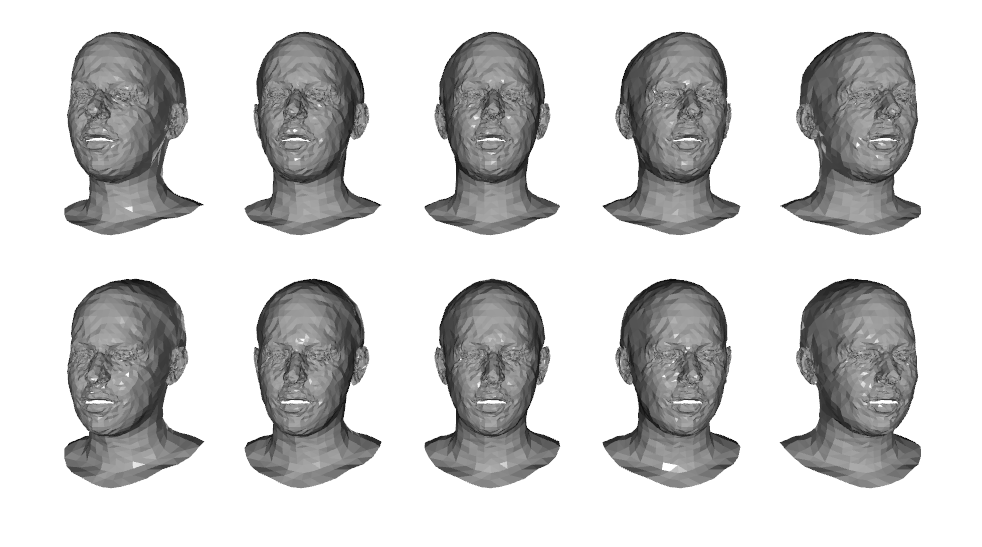

In [19]:
visualize(test_recons_meshes)

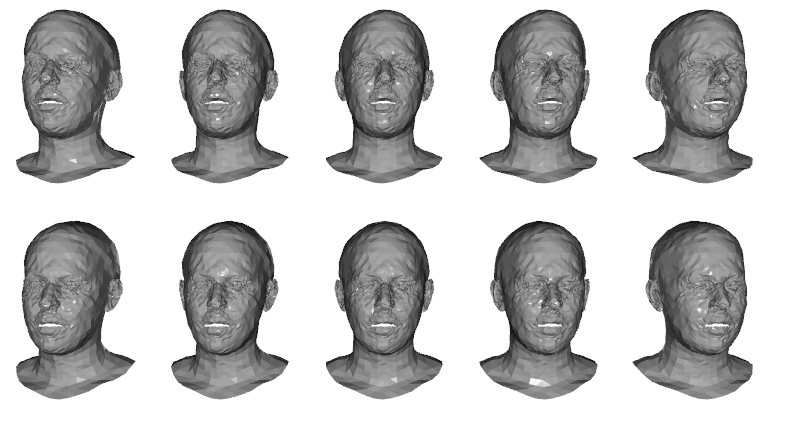

## Evaluation

In [20]:
type(X_train_v)

torch.Tensor

In [21]:
X_train_v = X_train_v.to('cpu').numpy()
X_train_v = X_train_v.reshape(-1, dx1*dx2)

X_test_v = X_test_v.to('cpu').numpy()
X_test_v = X_test_v.reshape(-1, dx1*dx2)

train_recons_vertices = train_recons_vertices.reshape(-1, dx1*dx2)
test_recons_vertices = test_recons_vertices.reshape(-1, dx1*dx2)

In [22]:
mse_train = mean_squared_error(X_train_v, train_recons_vertices)
mse_test = mean_squared_error(X_test_v, test_recons_vertices)

print(f'Train MSE: {mse_train}\nTest MSE: {mse_test}')

Train MSE: 5.106067419546889e-06
Test MSE: 5.392958428274142e-06
